# Generalized Linear Models (GLM)

> The enormous complexity of biophysically detailed multi-compartmental models at network-level generally prevents the derivation of interpretable descriptions that explain how neurons transform synaptic input into action potential output, and how these input-output computations depend on synaptic, cellular and network properties. Here we introduce an approach to reveal input-output computations that neurons in the cerebral cortex perform upon sensory stimulation. A realistic multi-scale cortex model is reduced to the minimal description that accounts for in vivo observed responses. 
> 
> Bast, A., Fruengel, R., De Kock, C. P. J., & Oberlaender, M. (2023).  Interpretable modelling of input-output computations in cortex [Preprint].  https://doi.org/10.1101/2023.08.29.555249

This tutorial will show how the enormous complexity of multiscale models can be reduced to the minimum sest of parameters that are required to explain the receptive field and latency of responses of the in-vivo conditions covered in the previous examples.

Adapt the path below to where you saved the data folder from https://doi.org/10.7910/DVN/QV7JIF (download from Harvard Dataverse)

In [5]:
BASEDIR = '/path/where/you/saved/data/' 

In [4]:
# append code repository to pythonpath
import sys
sys.path.append(BASEDIR + 'code')

In [7]:
# import from python ecosystem
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from functools import partial
import dask
from collections import defaultdict
from functools import partial
import distributed

In [9]:
%matplotlib inline

In [10]:
from data_base import DataBase
from visualize.histogram import histogram
from visualize.rasterplot import rasterplot
from data_base.analyze.temporal_binning import temporal_binning_pd

import Interface as I

In [12]:
# set up a dask cluster as described here: https://distributed.dask.org/en/stable/quickstart.html
client = I.get_client()
client

Client Scheduler: tcp://130.183.178.97:28786 Dashboard: http://130.183.178.97:28787/status,Cluster Workers: 20 Cores: 20 Memory: 2.00 TB


In [12]:
whiskers = ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E2']

In [16]:
models = range(1,8)

## Load multi-scale model simulation data

### Load pre-binned synapse activations

This is the synaptic input received by the multi-compartmental model (MCM) in principal whisker simulations. Another visualisation of this input can be seen in Fig. 1F, where the spatial distribution is also shown. 

In [15]:
model = 1
whisker = 'C2'

In [16]:
# each compressed numpy archive contains a single numpy array
sa = np.load(BASEDIR + "model_{}__binned_synapse_activations_spatiotemporal_EI__{}.npz".format(model, whisker))
sa = sa['arr_0']

In [17]:
sa.shape # (excitatory/inhibitory, spatial bins, trials, temporal bins)

(2, 30, 81000, 400)

In [18]:
saexc = sa[0, :, :, :]
sainh = sa[1, :, :, :]

In [19]:
# get mean count of active synapses onto the whole neuron in each timebin 
saexc_mean = saexc.sum(axis = 0).mean(axis = 0)
sainh_mean = sainh.sum(axis = 0).mean(axis = 0)

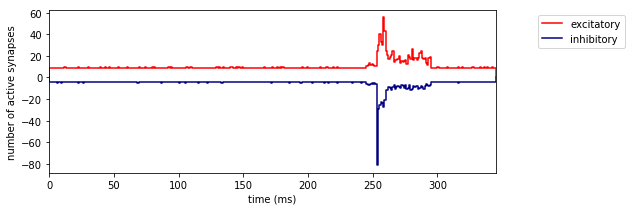

In [20]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(1,1,1)
histogram((list(range(401)), saexc_mean), fig = ax, label = 'excitatory', colormap = {'excitatory':'red'})
histogram((list(range(401)), sainh_mean * -1), fig = ax, label = 'inhibitory', colormap = {'inhibitory':'navy'})
plt.xlim(0, 345)
plt.ylabel('number of active synapses')
plt.legend(bbox_to_anchor = (1.3,1))
plt.xlabel('time (ms)')

### Visualise MCM responses

These are the responses of the MCM to the above synaptic input (also shown in Fig. 1I).

In [21]:
model = 1
whisker = 'C2'

In [22]:
# load spike times for a principal whisker stimulus
st = pd.read_csv(BASEDIR + "model_{}__spike_times_MCM__{}.csv".format(model, whisker)) 

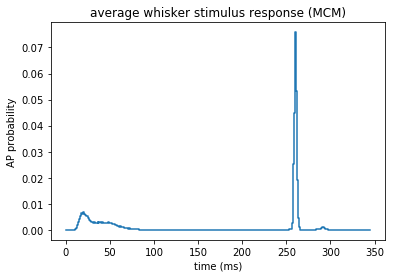

In [45]:
# the sensory stimulus was always applied at 245 ms, because
# the multi-compartmental model needs some time from initialisation to reach a steady state
# therefore the first 150 ms of each simulation should be discarded - spikes in this period are initialisation artefacts
ax = plt.gca()
histogram(temporal_binning_pd(st, min_time = 0, max_time = 345, bin_size = 1), fig = ax)
plt.ylabel('AP probability')
plt.xlabel('time (ms)')
plt.title('average whisker stimulus response (MCM)')

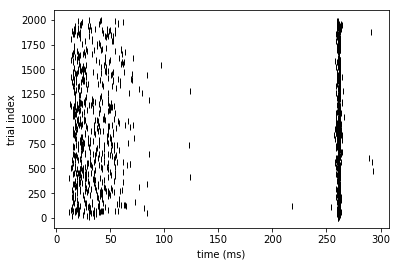

In [48]:
ax = plt.gca()
rasterplot(st[4000:6000], fig = ax)
plt.xlabel('time (ms)')
plt.ylabel('trial index')

## Reduced model inference

In [16]:
# we will store all the parameters of the reduced models in a dictionary
# here we show how to make a reduced model from one exemplary multi-compartmental model
# the procedure was repeated for all 7 MCMs
rm_dict = {}
rm_dict[model] = {}

In [17]:
import modular_reduced_model_inference
from modular_reduced_model_inference import RaisedCosineBasis

### RaisedCosine basis functions

The spatial and temporal filters are composed of a set of basis functions:

$w_\tau = \sum_i m_i f_i(\tau) \\
w_z = \sum_i n_i f_i(z)$

Here, $m$ and $n$ are learnable parameters, and the basis functions are raised cosines, which have the following form:

$f(x) = \frac{1}{2}cos(a \cdot log[x+c] - \phi_i) + \frac{1}{2}$

$a$, $c$ and $\phi$ are set depending on the required resolution. note that $\phi_i$ has a different value depending on the basis vector.  
The spatial filters need resolution close to the soma, so $a=3$, $c=5$ (see visualizations below)m, and we only require $6$ basis vectors.  
Temporal filters need resolution close to the AP onset, so $a=2$, $c=1$ (see visualizations below), and as we need more resolution, we have $20$ basis vectors.

In [18]:
RaisedCosineBasis_spatial = modular_reduced_model_inference.RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = modular_reduced_model_inference.RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)

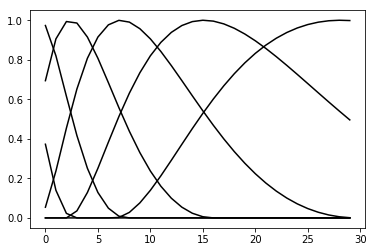

In [19]:
# the basis functions for the spatial filters
# the weight applied to each of these functions is the target of the optimiser
RaisedCosineBasis_spatial.visualize(plot_kwargs={'c': 'k', 'alpha': 1})

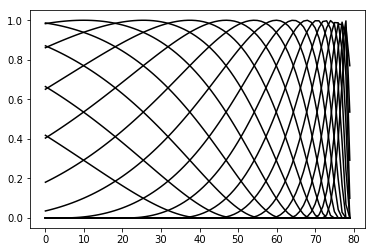

In [20]:
# the basis functions for the temporal filters
RaisedCosineBasis_temporal.visualize(plot_kwargs={'c': 'k', 'alpha': 1})

### Spatiotemporal filter inference

In [21]:
# we also provide precomputed spatiotemporal filters for all models used in our paper
# which are visualized in the next section

In [22]:
model = 1
whiskers = ['C2'] # it is also possible to infer reduced models from only a subset of the data. We use this here as an example, 
# with only the principal (C2) whisker. To run inference on the full dataset, uncomment the line below:
# whiskers = ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E2'] 
# be aware that a large amount of RAM is necessary to handle the full dataset

mdb_list = []
for whisker in whiskers:
    mdb_list.append({'spike_times': BASEDIR + "model_{}__spike_times_MCM__{}.csv".format(model, whisker),
           'binned_synapse_activation':BASEDIR + "model_{}__binned_synapse_activations_spatiotemporal_EI__{}.npz".format(model, whisker)})

In [24]:
# this cell takes a few minutes to run as it loads and uncompresses all the MCM simulation data
# uncompression takes a long time so you may want to save the uncompressed array in case you want to use it again
name = 'test'
rm = modular_reduced_model_inference.Rm(name, 
    mdb = mdb_list, 
    tmin = 260, #timepoint_of_max_response
    tmax = 261, #timepoint_of_max_response+1
    width = 80)

# make simulation data available to the reduced model
D = modular_reduced_model_inference.DataExtractor_spatiotemporalSynapseActivation
rm.add_data_extractor('spatiotemporalSa', D())
rm.add_data_extractor('st', modular_reduced_model_inference.DataExtractor_spiketimes())
rm.add_data_extractor('y', modular_reduced_model_inference.DataExtractor_spikeInInterval())
rm.add_data_extractor('ISI', modular_reduced_model_inference.DataExtractor_ISI())

The code above made the data available to the reduced model object, and cropped out data w.r.t. the selected timepoints

In [25]:
st = rm.data_extractors['st'].get() # spike times

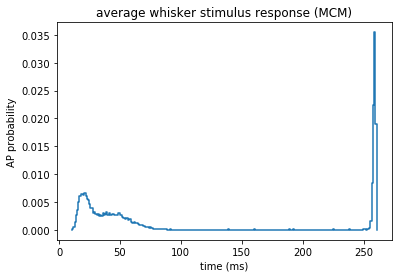

In [26]:
# the reduced model considers spike times up to tmax
ax = plt.gca()
histogram(temporal_binning_pd(st), fig = ax)
plt.ylabel('AP probability')
plt.xlabel('time (ms)')
plt.title('average whisker stimulus response (MCM)')

In [27]:
# define a strategy which evaluates simulation trials based on spatiotemporal filters
RaisedCosineBasis_spatial = RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)
len_z = len(RaisedCosineBasis_spatial.phis) # number of parameters of the spatial filter
len_t = len(RaisedCosineBasis_temporal.phis)  # number of parameters of the temporal filter
strategy = modular_reduced_model_inference.Strategy_spatiotemporalRaisedCosine('SAspatiotemporalRaisedCosine', RaisedCosineBasis_spatial, RaisedCosineBasis_temporal)

rm.add_strategy(strategy)

# add solver
solver = modular_reduced_model_inference.Solver_COBYLA('cobyla')
strategy.add_solver(solver)

for lv in range(3): # make 3 random train/test splits
    # rm.DataSplitEvaluation.add_random_split('.7_{}'.format(lv), percentage_train=.7)
    rm.DataSplitEvaluation.add_isi_dependent_random_split('ISI50_.7_{}'.format(lv),min_isi = 50, percentage_train=.7)

In [28]:
for lv in range(3):
    rm.run(client)

starting remote optimization SAspatiotemporalRaisedCosine cobyla
starting remote optimization SAspatiotemporalRaisedCosine cobyla
starting remote optimization SAspatiotemporalRaisedCosine cobyla


In [30]:
result_df = rm.get_results(client)
# If you get ValueError: Only one class present in y_true. ROC AUC score is not defined in that case, it means that the
# reduced model failed (this happens for example due to a lack of spikes in the interval used for inference)

In [31]:
result_df

score success  \
strategy                     solver split      subsplit run                     
SAspatiotemporalRaisedCosine cobyla ISI50_.7_0 subtest1 0   -0.992066   False   
                                                        1   -0.993329   False   
                                                        2   -0.992040   False   
                                               subtest2 0   -0.989921   False   
                                                        1   -0.990491   False   
                                                        2   -0.989427   False   
                                               test     0   -0.991523   False   
                                                        1   -0.992149   False   
                                                        2   -0.991154   False   
                                               train    0   -0.984188   False   
                                                        1   -0.985860   False   
                                                        2   -0.983728   False   
                                    ISI50_.7_1 subtest1 0   -0.992268   False   
                                                        1   -0.991068   False   
                                                        2   -0.990466   False   
                                               subtest2 0   -0.990166   False   
                                                        1   -0.989424   False   
                                                        2   -0.987997   False   
                                               test     0   -0.991684   False   
                                                        1   -0.990862   False   
                                                        2   -0.989854   False   
                                               train    0   -0.985018   False   
                                                        1   -0.982940   False   
                                                        2   -0.981275   False   
                                    ISI50_.7_2 subtest1 0   -0.992971    True   
                                                        1   -0.992882    True   
                                                        2   -0.992944   False   
                                               subtest2 0   -0.990368    True   
                                                        1   -0.990534    True   
                                                        2   -0.990600   False   
                                               test     0   -0.991989    True   
                                                        1   -0.992090    True   
                                                        2   -0.992083   False   
                                               train    0   -0.985961    True   
                                                        1   -0.985813    True   
                                                        2   -0.985702   False   

                                                                                                             x  
strategy                     solver split      subsplit run                                                     
SAspatiotemporalRaisedCosine cobyla ISI50_.7_0 subtest1 0    [0.959447821583, 0.127607023899, 1.0997403028,...  
                                                        1    [4.94194310094, 4.53524909301, 2.72658190132, ...  
                                                        2    [3.21385300474, 0.511869924346, 1.29909420539,...  
                                               subtest2 0    [0.959447821583, 0.127607023899, 1.0997403028,...  
                                                        1    [4.94194310094, 4.53524909301, 2.72658190132, ...  
                                                        2    [3.21385300474, 0.511869924346, 1.29909420539,...  
                                               test     0    [0.959447821583, 0.1

#### Visualize spatiotemporal filters

In [33]:
RaisedCosineBasis_spatial = RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)
strategy = modular_reduced_model_inference.Strategy_spatiotemporalRaisedCosine('SAspatiotemporalRaisedCosine', RaisedCosineBasis_spatial, RaisedCosineBasis_temporal)
# manually do what happens in rm.add_strategy(strategy) in order to get the shape of the basis functions
# this avoids having to load in the dataset
strategy.len_z = len(RaisedCosineBasis_spatial.phis) # number of parameters of the spatial filter
strategy.len_t = len(RaisedCosineBasis_temporal.phis)  # number of parameters of the temporal filter
strategy.groups = [('EXC',), ('INH',)] # excitatory and inhibitory
strategy.convert_x = partial(strategy._convert_x_static, strategy.groups, strategy.len_z)

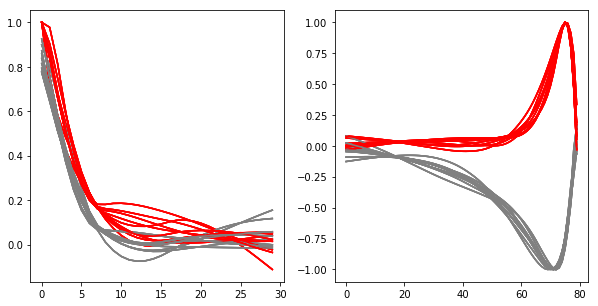

In [34]:
# the reduced model filters have one unconstrained parameter: they can be multiplied by a scalar
# normalize such that excitatory weight in the spatial filter at soma distance 0 is 1
strategy.visualize(result_df, normalize = True)

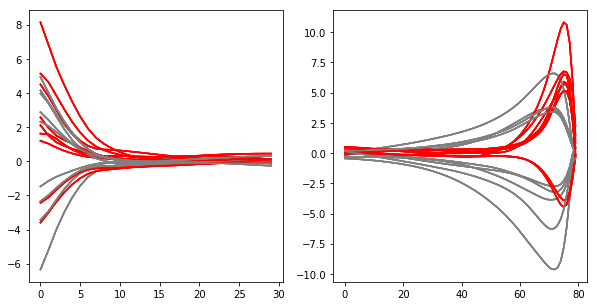

In [35]:
# visualize models before normalization
strategy.visualize(result_df, normalize = False)

In [36]:
# get numerical values of kernels visualized above
index_best_model = result_df.score.argmin()
spatiotemporal_filters = strategy.get_kernel_dict(result_df.loc[index_best_model].x, normalize = True)
spatiotemporal_filters

{'s_exc': array([ 0.99999994,  0.83999312,  0.67933828,  0.54754567,  0.42797816,
         0.32122907,  0.23403572,  0.16860136,  0.12514773,  0.09235044,
         0.06582323,  0.04554006,  0.03117438,  0.02222843,  0.01811939,
         0.01823592,  0.02197397,  0.0273118 ,  0.03221476,  0.03664161,
         0.04057404,  0.04400725,  0.04694676,  0.04940576,  0.05140304,
         0.05296133,  0.05410602,  0.05486407,  0.05526331,  0.05533172], dtype=float32),
 's_inh': array([  7.93388784e-01,   6.80935025e-01,   5.25943398e-01,
          3.73791099e-01,   2.47634768e-01,   1.55127957e-01,
          9.60600004e-02,   6.68410510e-02,   6.18851073e-02,
          6.21100441e-02,   6.06311373e-02,   5.78291751e-02,
          5.40423021e-02,   4.95610572e-02,   4.46290970e-02,
          3.94468531e-02,   3.41763236e-02,   2.90312413e-02,
          2.42002122e-02,   1.97337605e-02,   1.56642124e-02,
          1.20097343e-02,   8.77735205e-03,   5.96547779e-03,
          3.56593728e-03,   1.5

In [37]:
rm_dict[model]['spatiotemporal_filters'] = spatiotemporal_filters

### Calculate WNI values with spatiotemporal filters

In [86]:
# calculate all the WNI values at relevant timepoints - we will need them again to estimate the ISI-dependent penalty
@dask.delayed
def calculate_WNI_values(sa_file, kernel_dict, model, whisker, outdir):
    
    timebins = len(range(220, 271))

    sa = np.load(sa_file)
    sa = sa['arr_0']
    n_cells = sa.shape[2]
    WNI_df = pd.DataFrame(index = range(n_cells), columns = range(220, 271))
    SAexc = sa[0,:,:,:]
    SAinh = sa[1,:,:,:]
    

    SAexc = np.asarray(SAexc)
    SAinh = np.asarray(SAinh)
    
    s_exc = kernel_dict['s_exc']
    s_inh = kernel_dict['s_inh']
    t_exc = kernel_dict['t_exc']
    t_inh = kernel_dict['t_inh']

   

    SAinh_cumulative = np.ndarray((n_cells, 400))
    SAexc_cumulative = np.ndarray((n_cells, 400))

    for t, timebin in enumerate(range(220-80, 271)): # for all timebins relevant to period of interest
        ## get excitatory and inhibitory input, spatially binned for the CURRENT timebin
        SAexc_timebin = SAexc[:, :, timebin]
        SAinh_timebin = SAinh[:, :, timebin]

        ## apply spatial kernel to the current timebin
        SAexc_timebin = sum([o*s for o, s in zip(SAexc_timebin, s_exc)])
        SAinh_timebin = sum([o*s for o, s in zip(SAinh_timebin, s_inh)])



        for cell in range(n_cells):
            SAinh_cumulative[cell][timebin] = SAinh_timebin[cell]
            SAexc_cumulative[cell][timebin] = SAexc_timebin[cell]



    ## apply temporal kernel to timebins of interest
    for t, timebin in enumerate(range(220, 271)):
#         print timebin
        for cell in range(n_cells):

            SAexc_window = SAexc_cumulative[cell][timebin-79:timebin+1]
            SAinh_window = SAinh_cumulative[cell][timebin-79:timebin+1]



            SAexc_window = sum([o*s for o, s in zip(SAexc_window, t_exc)])
            SAinh_window = sum([o*s for o, s in zip(SAinh_window, t_inh)])

            ## get weighted net input for each cell
            WNI = SAexc_window + SAinh_window
            WNI_df.iloc[cell, t] = WNI
    name = 'model_{}__{}.csv'.format(model, whisker)
    WNI_df.to_csv(outdir + name)

In [ ]:
# we provide WNI values for the exemplary spatiotemporal filters generated in this notebook under the following key:
outdir = BASEDIR + 'precalculated_WNI_values__model_1__C2'

In [72]:
# to calculate them yourself, make a folder to store them in:
outdir = BASEDIR + 'precalculated_WNI_values/'
os.mkdir(outdir)

In [87]:
# takes about 20 mins per whisker on a single core
delayeds = []
index = []

for whisker in whiskers:   
    sa_file = BASEDIR + "model_{}__binned_synapse_activations_spatiotemporal_EI__{}.npz".format(model, whisker)
    d = calculate_WNI_values(sa_file, spatiotemporal_filters, model, whisker, outdir)
    delayeds.append(d)
    index.append((model, whisker))

In [88]:
# to prevent memory issues - each worker will load around 25GB of data
# adjust the number of cores working per node according to your memory limits
workers_per_node = 5
from itertools import groupby
workers = client.scheduler_info()['workers'].keys()
workers = sorted(workers, key = lambda x: x.split(':')[1])
w = [list(w)[:workers_per_node] for group, w in groupby(workers, lambda x: x.split(':')[1])]
w = [w for w in w for w in w]

In [89]:
futures = client.compute(delayeds, workers=w)

### Nonlinearity

In [91]:
def group_bins(helper_df, min_items = 10):
    # https://codereview.stackexchange.com/questions/12753/taking-the-first-few-items-of-a-list-until-a-target-sum-is-exceeded/12759

    total_items = 0
    rows_to_group = []
    groupings = []

    for row in range(len(helper_df.index)):

        items = helper_df.iloc[row, 3]
        total_items += items # keep a running total of number of datapoints
        rows_to_group.append(row)

        if total_items >= min_items: # once we have enough datapoints, save the grouping and continue
            total_items = 0
            groupings.append(rows_to_group)
            rows_to_group = []

        elif row == range(len(helper_df.index))[-1]: # or if it's the last bin, which might get skipped otherwise 
            groupings.append([row])

    # check if the last bin is too small, merge with second to last if it is
    last_binsize = 0
    for row in groupings[-1]:
        last_binsize += helper_df.iloc[row, 3]

    if last_binsize < min_items:
        new_grouping = groupings[:-2]
        last_bins = groupings[-2:]
        new_grouping.append([i for sublist in last_bins for i in sublist])
        groupings = new_grouping
    
    return groupings

def signchange(x,y):
    if x / abs(x) == y / abs(y):
        return False
    else:
        return True

def linear_interpolation_between_pairs(X,Y, x, top = 'inf', bottom = 'min'):
    if x > max(X):
        if top == 'inf':
            result = np.inf
        elif top == 'max':
            result = max(Y)
    elif x < min(X):
        if bottom == 'inf':
            result = -np.inf
        elif bottom == 'min':
            result = min(Y)        
    elif float(x) in X: # don't need to interpolate, causes assertion error
        result = Y[X.index(x)]
    else:
        pair = [lv for lv in range(len(X)-1) if signchange(X[lv]-x, X[lv+1]-x)]
#         X[lv] <= x < X[lv + 1]]
        assert(len(pair) == 1)
        pair = pair[0]
        m = (Y[pair+1]-Y[pair]) / (X[pair+1]-X[pair])
        c = Y[pair]-X[pair]*m

        result = m*x+c
    return result

def variable_stepsize_nonlinearity(wni_values, spike_times, spike_before = None, lookup_series_stepsize = 3, min_items = 10):
    pdf2 = pd.DataFrame(dict(wni_values = wni_values, spike = spike_times))
    if spike_before is not None:
        pdf = pdf2[~spike_before]
    else:
        pdf = pdf2

    bins = range(int(np.floor(pdf['wni_values'].min())), int(np.floor(pdf['wni_values'].max())) + lookup_series_stepsize + 1, lookup_series_stepsize)
    pdf['bin'] = pd.cut(pdf['wni_values'], bins, include_lowest=True)

    helper_df = pd.DataFrame()

    edges = []
    spike_prob = []
    n_items = []
    spikes = []
    for b in set(pdf['bin']):
        b_pdf = pdf[pdf['bin'] == b]
        n_items.append(len(b_pdf))
        edges.append(int(b.split(',')[0][1:]))
        spike_prob.append(np.mean(b_pdf['spike']))
        spikes.append(list(b_pdf['spike']))

    helper_df['bin_start'] = edges
    helper_df['spike_prob'] = spike_prob
    helper_df['spikes'] = spikes
    helper_df['n_items'] = n_items
    helper_df.sort_values('bin_start', inplace = True)

    bin_groupings = group_bins(helper_df, min_items = min_items)
    new_df = pd.DataFrame(columns = ['bin_start', 'spike_prob'], index = range(len(bin_groupings)))

    bin_starts = []
    spike_probs = []
    for g in bin_groupings:
        if len(g) == 1:
            bin_starts.append(helper_df.iloc[g[0], 0])
            spike_probs.append(helper_df.iloc[g[0], 1])
        else:
            bin_starts.append(helper_df.iloc[g[0], 0])
            spikes = []
            for row in g:
                spikes.append(helper_df.iloc[row, 2])

            spikes = [i for sublist in spikes for i in sublist]
            assert len(spikes) >= min_items
            spike_probs.append(np.mean(spikes))


    points = []
    for n, b in enumerate(bin_starts):
        midpoint = b + (lookup_series_stepsize * len(bin_groupings[n]))/2.
        points.append((midpoint, spike_probs[n]))

    points = sorted(points)
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]

    diff = max(x_points) - min(x_points)
    index = np.arange(int(min(x_points) - 0.3 * diff), int(max(x_points) + 0.3 * diff))

    LUT = pd.Series(index = index)
    for i in index:
        LUT[i] = linear_interpolation_between_pairs(x_points,y_points, i, top = 'max')
        
    return LUT

In [92]:
from model_data_base.analyze.spike_detection import spike_in_interval

In [ ]:
outdir = BASEDIR + 'precalculated_WNI_values/'

In [95]:
rm_inference_timepoint = 260
WNI_df = []
spike_times_df = []
for whisker in whiskers:
    spike_times_df.append(pd.read_csv(BASEDIR + "/{}/spike_times_MCM/{}.csv".format(model, whisker)))
    
     # adapt according to where you saved (this loads the provided precalculated WNI values for C2 whisker)
    WNI_df.append(pd.read_csv('precalculated_WNI_values__model_1__{}'.format(whisker)))

#     key = '{}__{}.csv'.format(model, whisker)
#     WNI_df.append(pd.read_csv(outdir + key))
    
WNI_df = pd.concat(WNI_df)
spike_times_df = pd.concat(spike_times_df)


tdf = WNI_df.loc[:, str(rm_inference_timepoint)]
wni_values = np.asarray(tdf)
spike_times = np.asarray(spike_in_interval(spike_times_df, rm_inference_timepoint, rm_inference_timepoint + 1)) 
assert len(wni_values) == len(spike_times)

rp = 15 # filter out trials with a spike in the last X ms
spike_before =  np.asarray(spike_in_interval(spike_times_df, rm_inference_timepoint - rp, rm_inference_timepoint))

nonlinearity = variable_stepsize_nonlinearity(wni_values, spike_times, spike_before = spike_before)

/axon/scratch/rfruengel/anaconda2_isf/lib/python2.7/site-packages/ipykernel/__main__.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


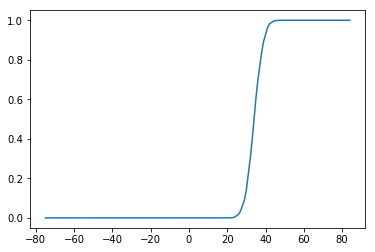

In [96]:
plt.plot(nonlinearity)

In [97]:
rm_dict[model]['nonlinearity'] = nonlinearity

### ISI-dependent penalty

In [ ]:
outdir = BASEDIR + 'precalculated_WNI_values/'

In [104]:
def fetch_ISI_WNI_data(model, rm_inference_timepoint):
    st = pd.concat([pd.read_csv(BASEDIR + "model_{}__spike_times_MCM__{}.csv".format(model, whisker)) for whisker in whiskers])
    # is there a spike in the estimation period?
    st['spike_in_interval'] = spike_in_interval(st, rm_inference_timepoint, rm_inference_timepoint + 1)
    # how long ago was the most recent spike?
    st[st>rm_inference_timepoint] = np.NaN
    st['ISI'] = st.max(axis=1) - rm_inference_timepoint

    # collect WNI values and add them to the dataframe
    wni = pd.DataFrame()
    for whisker in whiskers:
        # adapt according to where you saved (this loads the provided precalculated WNI values for C2 whisker)
        wni_path = 'precalculated_WNI_values__model_1__{}'.format(whisker)
#         wni_path = outdir + '{}__{}.csv'.format(model, whisker)
        wni = pd.concat([wni, pd.read_csv(wni_path)])

    st['wni_value'] = np.asarray(wni.loc[:, str(rm_inference_timepoint)])
    

    spike_df = st[st.spike_in_interval & (st.ISI > -80) & (st.ISI < 0)]
    no_spike_df = st[~st.spike_in_interval & (st.ISI > -80) & (st.ISI < 0)]
    
    spike_isi = spike_df['ISI']
    spike_wni = spike_df['wni_value']
    
    no_spike_isi = no_spike_df['ISI']
    no_spike_wni = no_spike_df['wni_value']

    return spike_isi, spike_wni, no_spike_isi, no_spike_wni, st

In [131]:
def get_isi_boundary_95(spike_isi, spike_wni):
    def signchange(x,y):
        if x / abs(x) == y / abs(y):
            return False
        else:
            return True
    
    def linear_interpolation_between_pairs(X,Y, x):
        if x > max(X):
            result = np.inf
        elif x < min(X):
            result = min(Y)
        elif float(x) in X: # don't need to interpolate, causes assertion error
            result = Y[X.index(x)]
        else:
            pair = [lv for lv in range(len(X)-1) if signchange(X[lv]-x, X[lv+1]-x)]
    #         X[lv] <= x < X[lv + 1]]
            assert(len(pair) == 1)
            pair = pair[0]
            m = (Y[pair+1]-Y[pair]) / (X[pair+1]-X[pair])
            c = Y[pair]-X[pair]*m

            result = m*x+c
        return result
    
    l = zip(spike_isi, spike_wni)
    if len(l) < 2:
        return I.np.nan
    l = sorted(l, key = lambda x: x[1]) # sort by WNI values
    to_drop = len(spike_wni) / 20 # drop lowest 5%
    l = l[to_drop:]
    
    l = sorted(l, key = lambda x: x[0], reverse = True) # sort by ISI again
    
    points = []
    points.append([l[0][0], l[0][1]])
    y_min = l[0][1]
    for x, y in l:
        if y < y_min:
            points.append([x, y])
            y_min = y
            
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]

    ISI_boundary = pd.Series(index = range(-80, 0))

    for ISI in ISI_boundary.index:
        ISI_boundary[ISI] = linear_interpolation_between_pairs(x_points, y_points, ISI)
        
    return ISI_boundary

In [132]:
spike_isi, spike_wni, no_spike_isi, no_spike_wni, st = fetch_ISI_WNI_data(1, rm_inference_timepoint)

In [133]:
ISI_penalty = get_isi_boundary_95(spike_isi, spike_wni)

In [134]:
def plot_ISI_cloud(ax, spike_isi, spike_wni, no_spike_isi, no_spike_wni, s = 2):
    ax.scatter(no_spike_isi, no_spike_wni, c = 'k', s = s, rasterized = True)
    ax.scatter(spike_isi, spike_wni, c = 'r', s = s, rasterized = True)
    ax.legend(['no spike', 'spike'])
    ax.set_xlim(-85, 5)
    ax.set_ylim(-30, 120)
    ax.set_xlabel('inter spike interval (ms)')
    ax.set_ylabel('weighted net input')

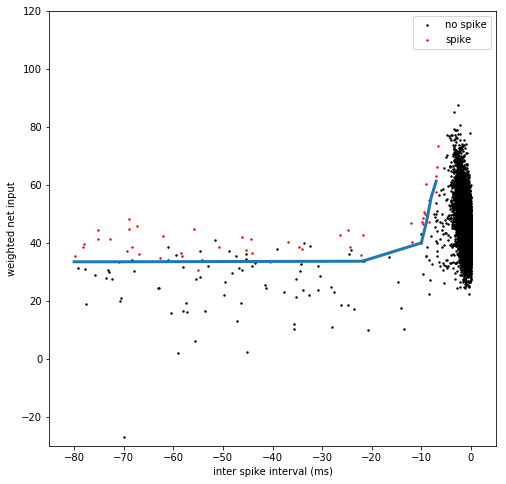

In [135]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()
plot_ISI_cloud(ax, spike_isi, spike_wni, no_spike_isi, no_spike_wni)
plt.plot(ISI_penalty, linewidth = 3)

In [136]:
# when using the ISI-dependent penalty for simulations, you should subtract the baseline value, i.e.
ISI_penalty_simulations = ISI_penalty - min(ISI_penalty)

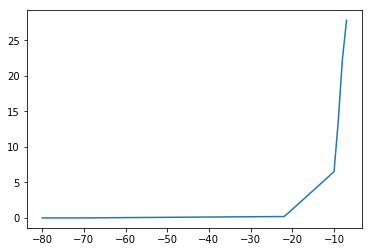

In [137]:
plt.plot(ISI_penalty_simulations)

In [142]:
rm_dict[model]['ISI_penalty'] = ISI_penalty

## Reduced model simulations

In [17]:
import json
import seaborn as sns

In [157]:
# load reduced models which we provide, or use ones that you generated above
rm_dict = {}
for model in range(1,8):
    with open(BASEDIR + "model_{}__reduced_model_parameters.txt".format(model), "r") as fp:
        rm = json.load(fp)
    rm_dict[model] = rm

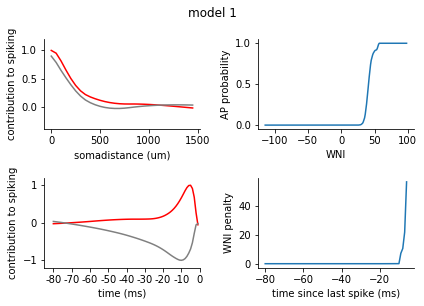

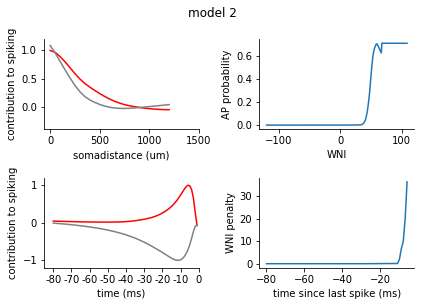

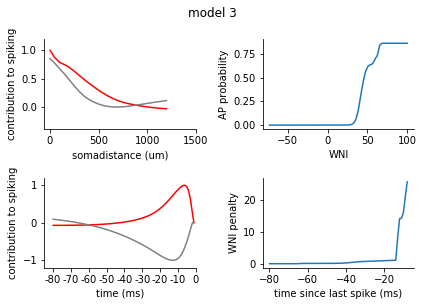

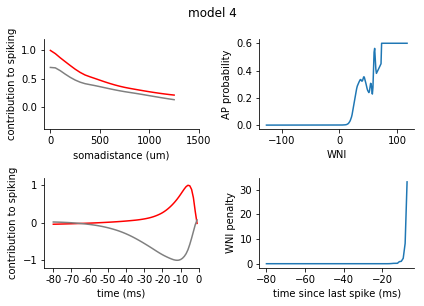

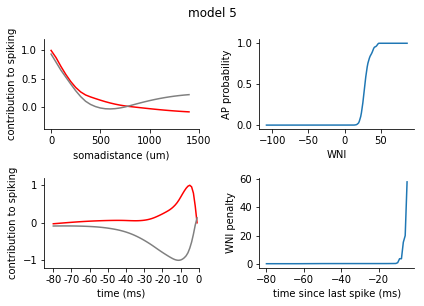

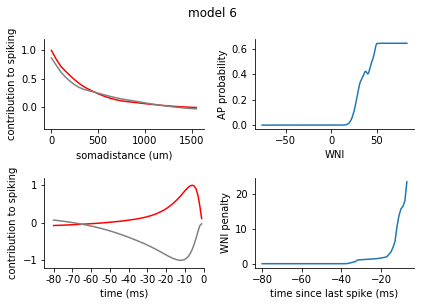

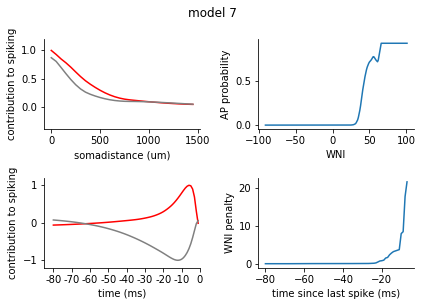

In [21]:
for model in range(1, 8):
    fig = plt.figure()
    plt.suptitle('model {}'.format(model), y = 1.05)

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,3)
    filters = rm_dict[model]['spatiotemporal_filters']
    s_exc = filters['s_exc']
    s_inh = filters['s_inh']
    t_exc = filters['t_exc']
    t_inh = filters['t_inh']

    ax1.plot(s_exc, c = 'r')
    ax1.plot(s_inh, c = 'grey')
    ax1.set_xticks([0,10,20, 30])
    ax1.set_xticklabels([0, 500, 1000, 1500])
    ax1.set_xlabel('somadistance (um)')

    ax2.plot(t_exc, c = 'r')
    ax2.plot(t_inh, c = 'grey')
    ax2.set_xticks(range(0, 85, 10))
    ax2.set_xticklabels(range(-80, 5, 10))
    ax2.set_xlabel('time (ms)')

    ax1.set_ylim(-0.4, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax1.set_ylabel('contribution to spiking')
    ax2.set_ylabel('contribution to spiking')
    ax2.set_xlim(-5, 80)
    
    nonlinearity = pd.Series(rm_dict[model]['nonlinearity'])
    nonlinearity.index = nonlinearity.index.astype(int)
    nonlinearity = nonlinearity.sort_index()
    ax3 = fig.add_subplot(2,2,2)
    ax3.plot(nonlinearity)
    ax3.set_ylabel('AP probability')
    ax3.set_xlabel('WNI')

    penalty = pd.Series(rm_dict[model]['ISI_penalty'])
    penalty.index = penalty.index.astype(int)
    penalty = penalty.sort_index()
    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(penalty)
    ax4.set_ylabel('WNI penalty')
    ax4.set_xlabel('time since last spike (ms)')
        
    plt.tight_layout()
    sns.despine()
    plt.show()

In [140]:
class ReducedModel:
    def __init__(self, kernel_dict, LUT, ISI_penalty, spatial_bin_size = 50):
        self.kernel_dict = kernel_dict
        self.LUT = LUT
        self.ISI_penalty = ISI_penalty
        self.spatial_bin_size = spatial_bin_size

    def run(self, SAexc, SAinh, return_WNI = False):
        '''Apply the reduced model to synaptic input to get a list containing output spike times.
        SAexc, SAinh: numpy arrays containing spatiotemporally binned synaptic inputs, shape (spatial bins, trials, temporal bins)
        return_WNI: bool
            full_trace returns a dataframe containing WNI values at all timepoints along with spike times. 
            False returns spike times dataframe only.'''
        s_exc = self.kernel_dict['s_exc']
        s_inh = self.kernel_dict['s_inh']
        t_exc = self.kernel_dict['t_exc']
        t_inh = self.kernel_dict['t_inh']
        
        assert SAexc.shape == SAinh.shape

        LUT = self.LUT

        WNI_boundary = self.ISI_penalty
        
        spatial_bins = SAexc.shape[0]
        n_trials = SAexc.shape[1]
        timebins = SAexc.shape[2]
        
        WNI_df = pd.DataFrame(index = range(n_trials), columns = range(timebins))

        SAinh_cumulative = np.zeros((n_trials, timebins))
        SAexc_cumulative = np.zeros((n_trials, timebins))

        spike_times_df = pd.DataFrame(index = range(n_trials))

        for timebin in range(timebins):
            ## get excitatory and inhibitory input, spatially binned for the CURRENT timebin
            SAexc_timebin = np.ndarray((spatial_bins, n_trials, 1))
            for dist in range(spatial_bins):
                for cell in range(n_trials):
                    SAexc_timebin[dist][cell] = SAexc[dist][cell][timebin]

            SAinh_timebin = np.ndarray((spatial_bins, n_trials, 1))
            for dist in range(spatial_bins):
                for cell in range(n_trials):
                    SAinh_timebin[dist][cell] = SAinh[dist][cell][timebin]

            ## apply spatial kernel to the current timebin
            SAexc_timebin = sum([o*s for o, s in zip(SAexc_timebin, s_exc)])
            SAinh_timebin = sum([o*s for o, s in zip(SAinh_timebin, s_inh)])



            for cell in range(n_trials):
                SAinh_cumulative[cell][timebin] = SAinh_timebin[cell]
                SAexc_cumulative[cell][timebin] = SAexc_timebin[cell]



            ## apply temporal kernel
            spikes = []
            for cell in range(n_trials):
                if timebin - 80 >= 0:
                    SAexc_window = SAexc_cumulative[cell][timebin-79:timebin+1]
                    SAinh_window = SAinh_cumulative[cell][timebin-79:timebin+1]
                else:
                    SAexc_window = SAexc_cumulative[cell][0:timebin+1]
                    SAinh_window = SAinh_cumulative[cell][0:timebin+1]


                SAexc_window = sum([o*s for o, s in zip(SAexc_window, t_exc[-len(SAexc_window):])])
                SAinh_window = sum([o*s for o, s in zip(SAinh_window, t_inh[-len(SAinh_window):])])

                ## get weighted net input for each cell
                WNI = SAexc_window + SAinh_window
                WNI_df.iloc[cell, timebin] = WNI

                # check the last 80 bins for a spike, apply WNI penalty if there was
                min_index = 0 if timebin < 80 else timebin-80
                if sum(spike_times_df.iloc[cell, min_index:timebin]) > 0: #if there was a spike in the last 80 ms
                    last_spike_interval = 80 - np.where(spike_times_df.iloc[cell, min_index:timebin] == 1)[0][-1]
                    penalty = WNI_boundary[-last_spike_interval]
                    WNI -= penalty


                ## get spike probability from WNI
                if WNI > LUT.index.max():
                    spiking_probability = LUT[LUT.index.max()]
                elif WNI < LUT.index.min():
                    spiking_probability = LUT[LUT.index.min()]
                else:
                    spiking_probability = LUT[np.round(WNI)]

                ## spike or not?
                if spiking_probability > np.random.uniform(): 
                    spikes.append(1)
                else:
                    spikes.append(0)
                    
            spike_times_df[str(timebin)] = spikes     
                
        if return_WNI:
            return spike_times_df, WNI_df
        else:
            return spike_times_df

In [ ]:
model = 1
filters = rm_dict[model]['spatiotemporal_filters']
nonlinearity = pd.Series(rm_dict[model]['nonlinearity'])
nonlinearity.index = nonlinearity.index.astype(int)
nonlinearity = nonlinearity.sort_index() 
    
penalty = pd.Series(rm_dict[model]['ISI_penalty'])
penalty.index = penalty.index.astype(int)
penalty = penalty.sort_index()

In [144]:
rm = ReducedModel(filters, nonlinearity, penalty)

In [145]:
sa = np.load(BASEDIR + "model_{}__binned_synapse_activations_spatiotemporal_EI__{}.npz".format(model, whisker))
sa = sa['arr_0']
SAexc = sa[0,:,:,:]
SAinh = sa[1,:,:,:]

In [146]:
SAexc.shape, SAinh.shape # (spatial bins, trials ,temporal bins)

((30, 81000, 400), (30, 81000, 400))

In [147]:
spike_times = rm.run(SAexc[:, 4000:6000, :], SAinh[:, 4000:6000, :]) # select the same trials as we visualised for the MCM

In [148]:
spike_times

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
# reformat the spike times so that instead of 1 or 0 for each timebin per cell, each cell has a list of its spike times
st_reformat = pd.DataFrame(index = range(len(spike_times.index)), columns = range(max(spike_times.sum(axis = 1))))
for cell in spike_times.index:
    nspikes = 0
    for timebin in spike_times.columns:
        if spike_times.iloc[cell, int(timebin)] == 1:
            st_reformat.iloc[cell, nspikes] = int(timebin)
            nspikes += 1

(0, 300)

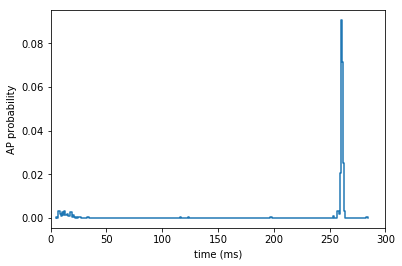

In [150]:
# the sensory stimulus was always applied at 245 ms
ax = plt.gca()
histogram(temporal_binning_pd(st_reformat), fig = ax)
plt.ylabel('AP probability')
plt.xlabel('time (ms)')
plt.xlim(0, 300)

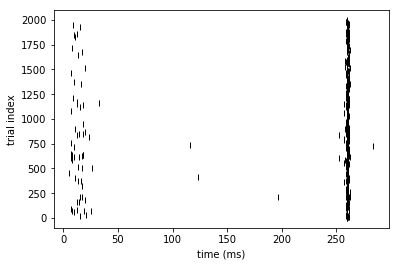

In [151]:
ax = plt.gca()
rasterplot(st_reformat, fig = ax)
plt.xlabel('time (ms)')
plt.ylabel('trial index')